In [1]:
import pandas as pd
import xgboost
import catboost
import sqlite3
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 데이터 불러오기
~~~
테이블 이름 : DVC0003, DVC0004, DVC0005
~~~

> * #### 1. 데이터 불러오기
> * #### 2. 데이터 확인
>   * ##### a. DVC 별 .info() 확인
>   * ##### b. 정상/비정상 별 데이터 개수 확인
> * #### 3. 데이터 전처리
>   * ##### a. 문자열 칼럼 삭제
>   * ##### b. 학습 데이터 셋 생성

#### 데이터 불러오기 - 1. 데이터 불러오기

In [2]:
# 1. 데이터 불러오기

conn = sqlite3.connect("../data/Database.db")
cursor = conn.cursor()

query_003 = "SELECT * FROM DVC0003"
query_004 = "SELECT * FROM DVC0004"
query_005 = "SELECT * FROM DVC0005"

df_0003 = pd.read_sql_query(query_003, conn)
df_0004 = pd.read_sql_query(query_004, conn)
df_0005 = pd.read_sql_query(query_005, conn)

# 추후 데이터 가공시 편하게 하기 위해 리스트에 변수들 담음
list_df = [df_0003, df_0004, df_0005]

#### 데이터 불러오기 - 2. 데이터 확인

In [3]:
# 2 .데이터 확인
#   a. .info() 데이터 확인

for df in list_df:
    vnames = [name for name in globals() if globals()[name] is df][0]

    print("dataframe 이름")
    print(df.info())
    print('==========================================================')

dataframe 이름
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833349 entries, 0 to 833348
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   MODELNO               833349 non-null  object 
 1   DEVICECODE            833349 non-null  object 
 2   MP_PRDTIME            833349 non-null  object 
 3   STATUS_MS             833349 non-null  int64  
 4   MP_MINUTE             833349 non-null  object 
 5   System Pressure       833349 non-null  float64
 6   Discharge Pressure    833349 non-null  float64
 7   Stage 3 Inlet Temp    833349 non-null  float64
 8   Stage 1 Vibration     833349 non-null  float64
 9   Stage 2 Vibration     833349 non-null  float64
 10  Stage 3 Vibration     833349 non-null  float64
 11  Oil Pressure          833349 non-null  float64
 12  Oil Temperature       833349 non-null  float64
 13  Drive Motor Current   833349 non-null  float64
 14  Surge Count           833349 non-null  

In [4]:
# 2 .데이터 확인
#   b. 정상/비정상 별 데이터 개수 확인

for df in list_df:
    # 변수이름 추출
    vnames = [name for name in globals() if globals()[name] is df]

    print("df 이름 : {}".format(vnames[0]))
    print("---------------------")
    print("전체 데이터 개수 : {}".format(len(df)))
    print("정상 데이터 갯수: ", len(df[df.STATUS_MS==1]))
    print("비정상 데이터 갯수: ", len(df[df.STATUS_MS==2]))
    print("\n")


df 이름 : df_0003
---------------------
전체 데이터 개수 : 833349
정상 데이터 갯수:  832307
비정상 데이터 갯수:  1042


df 이름 : df_0004
---------------------
전체 데이터 개수 : 833284
정상 데이터 갯수:  833263
비정상 데이터 갯수:  21


df 이름 : df_0005
---------------------
전체 데이터 개수 : 833336
정상 데이터 갯수:  833327
비정상 데이터 갯수:  9




#### 데이터 불러오기 - 3. 데이터 전처리

In [5]:
# 3. 데이터 전처리
#   a. 문자열 칼럼 삭제
import copy

del_column_list = ["MODELNO", "DEVICECODE", "MP_PRDTIME", "MP_MINUTE"]

# 동적 변수로 전처리 df 생성
# pp_df_0003, pp_df_0004, pp_df_0005
for df in list_df: 
    vnames = [name for name in globals() if globals()[name] is df]
    drop_df = df.drop(del_column_list, axis = "columns")
    drop_df["STATUS_MS"] = drop_df["STATUS_MS"].replace({1 : 0, 2 : 1})

    globals()["pp_{}".format(vnames[0])] = copy.deepcopy(drop_df)

# 전처리 된 데이터 리스트에 담아서 관리
pp_df_list = [pp_df_0003, pp_df_0004, pp_df_0005]    

## SHAP 모델 생성
~~~
모델 종류 : XGBoost, CatBoost
~~~

> * ### 1. 테스트 모델 생성
>   > SHAP 모델에 전달하기 위한 TEST 모델 생성
>   * ##### a. xgBoost 모델 생성
>   * ##### 2. catBoost 모델 생성
> * ### 2. 테스트 모델 성능 측정
>   * ##### a. DVM 별 xgboost 모델에 대한 성능 확인
>   * ##### b. DVM 별 catboost 모델에 대한 성능 확인
> * ### 3. Shap 모델 생성 및 Shap value 그래프 확인
>   * ##### a. DVM 별 xgboost 모델 생성 및 shap value 확인
>   * ##### b. DVM 별 catboost 모델 생성 및 shap value 확인

#### SHAP 모델 생성 - 1. 테스트 모델 생성

In [6]:
import copy

for train_df in pp_df_list:
    vnames = [name for name in globals() if globals()[name] is train_df][0]
    dvc_number = vnames.split("_")[-1]
    
    x = train_df.drop(["STATUS_MS"], axis = "columns")
    y = train_df["STATUS_MS"]

    # 데이터 셋 분 리 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

    print("학습 데이터 이름 : ",vnames)

    # 따로 전역변수 저장이유 : Shap 모델 생성시, 판별 X 데이터가 필요함
    globals()["x_train_{}".format(dvc_number)] = copy.deepcopy(x_train)
    globals()["y_train_{}".format(dvc_number)] = copy.deepcopy(y_train)
    globals()["x_test_{}".format(dvc_number)] = copy.deepcopy(x_test)
    globals()["y_test_{}".format(dvc_number)] = copy.deepcopy(y_test)

    # 1. xgboost 모델 생성 -> xgb_0003, xgb_0004, xgb_0005 모델 생성
    globals()["xgb_{}".format(dvc_number)] = xgboost.XGBClassifier().fit(x_train, y_train, verbose = 0)    

    # 2. catboost 모델 생성 -> cat_0003, cat_0004, cat_0005 모델 생성
    # verbose = 0 -> 로그 끄기
    globals()["cat_{}".format(dvc_number)] = catboost.CatBoostClassifier().fit(x_train, y_train, verbose=0)

    # 3. 각 생성된 모델별 predeict 값 추출
    globals()["y_pred_xgb_{}".format(dvc_number)] = globals()["xgb_{}".format(dvc_number)].predict(x_test)
    globals()["y_pred_cat_{}".format(dvc_number)] = globals()["cat_{}".format(dvc_number)].predict(x_test)

학습 데이터 이름 :  pp_df_0003


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

학습 데이터 이름 :  pp_df_0004


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

학습 데이터 이름 :  pp_df_0005


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

#### SHAP 모델 생성 - 2. 테스트 모델 성능 측정

In [10]:
# 설비별 실제 y 데이터 리스트
y_test_list = [y_test_0003,y_test_0004, y_test_0005]

In [18]:
# xgboost 에 대한 설비별 성능 측정

xgb_pred_data_list = [y_pred_xgb_0003, y_pred_xgb_0004, y_pred_xgb_0005]

for dvc_num, pred_data in enumerate(xgb_pred_data_list):
    vnames = [name for name in globals() if globals()[name] is pred_data][0]

    accuracy = accuracy_score(y_test_list[dvc_num], pred_data)
    precision = precision_score(y_test_list[dvc_num], pred_data)
    recall = recall_score(y_test_list[dvc_num], pred_data)
    f1 = f1_score(y_test_list[dvc_num], pred_data)
    roc_auc = roc_auc_score(y_test_list[dvc_num], pred_data)

    print("++++++++++점수판(xgboost)[{}]++++++++++".format(vnames))
    print("정확도: {:.3f}".format(accuracy))
    print("정밀도: {:.3f}".format(precision))
    print("재현율: {:.3f}".format(recall))
    print("F1 스코어: {:.3f}".format(f1))
    print("AUC-ROC: {:.3f}".format(roc_auc))
    print("-------------------------------------------------")

++++++++++점수판(xgboost)[y_pred_xgb_0003]++++++++++
정확도: 1.000
정밀도: 1.000
재현율: 1.000
F1 스코어: 1.000
AUC-ROC: 1.000
-------------------------------------------------
++++++++++점수판(xgboost)[y_pred_xgb_0004]++++++++++
정확도: 1.000
정밀도: 0.667
재현율: 0.800
F1 스코어: 0.727
AUC-ROC: 0.900
-------------------------------------------------
++++++++++점수판(xgboost)[y_pred_xgb_0005]++++++++++
정확도: 1.000
정밀도: 0.000
재현율: 0.000
F1 스코어: 0.000
AUC-ROC: 0.500
-------------------------------------------------


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [20]:
# catboost 에 대한 설비별 성능 측정
cat_pred_data_list = [y_pred_cat_0003, y_pred_cat_0004, y_pred_cat_0005]

for index, pred_data in enumerate(cat_pred_data_list):
    vnames = [name for name in globals() if globals()[name] is pred_data][0]

    accuracy = accuracy_score(y_test_list[index], pred_data)
    precision = precision_score(y_test_list[index], pred_data)
    recall = recall_score(y_test_list[index], pred_data)
    f1 = f1_score(y_test_list[index], pred_data)
    roc_auc = roc_auc_score(y_test_list[index], pred_data)

    print("++++++++++점수판(catboost)[{}]++++++++++".format(vnames))
    print("정확도: {:.3f}".format(accuracy))
    print("정밀도: {:.3f}".format(precision))
    print("재현율: {:.3f}".format(recall))
    print("F1 스코어: {:.3f}".format(f1))
    print("AUC-ROC: {:.3f}".format(roc_auc))
    print("-------------------------------------------------")

++++++++++점수판(catboost)[y_pred_cat_0003]++++++++++
정확도: 1.000
정밀도: 1.000
재현율: 1.000
F1 스코어: 1.000
AUC-ROC: 1.000
-------------------------------------------------
++++++++++점수판(catboost)[y_pred_cat_0004]++++++++++
정확도: 1.000
정밀도: 0.667
재현율: 0.800
F1 스코어: 0.727
AUC-ROC: 0.900
-------------------------------------------------
++++++++++점수판(catboost)[y_pred_cat_0005]++++++++++
정확도: 1.000
정밀도: 1.000
재현율: 1.000
F1 스코어: 1.000
AUC-ROC: 1.000
-------------------------------------------------


#### SHAP 모델 생성 - 2. Shap 모델 생성 및 Shap value 그래프 확인

In [21]:
# XGBoost 모델에 대한 shap value 구하기

explainer_xgb_0003 = shap.Explainer(xgb_0003)
shap_value_xgb_0003 = explainer_xgb_0003(x_train_0003)

explainer_xgb_0004 = shap.Explainer(xgb_0004)
shap_value_xgb_0004 = explainer_xgb_0004(x_train_0004)

explainer_xgb_0005 = shap.Explainer(xgb_0005)
shap_value_xgb_0005 = explainer_xgb_0005(x_train_0005)

[10:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
[10:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a fut

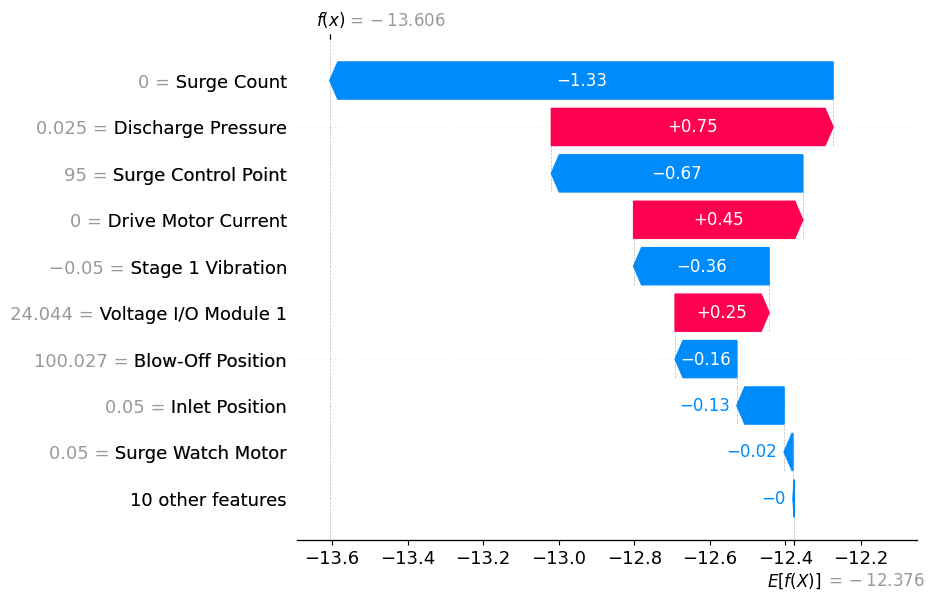

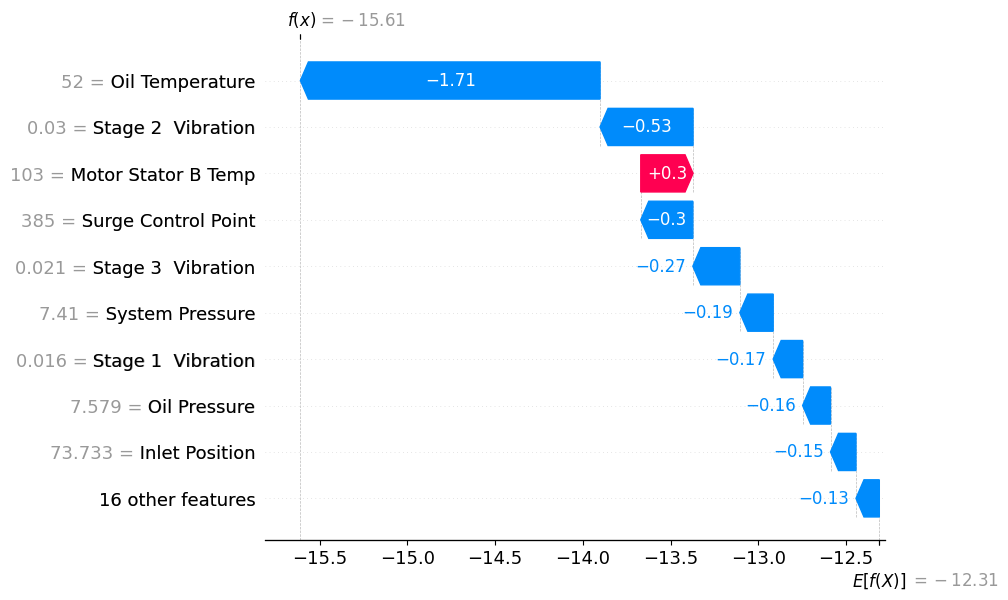

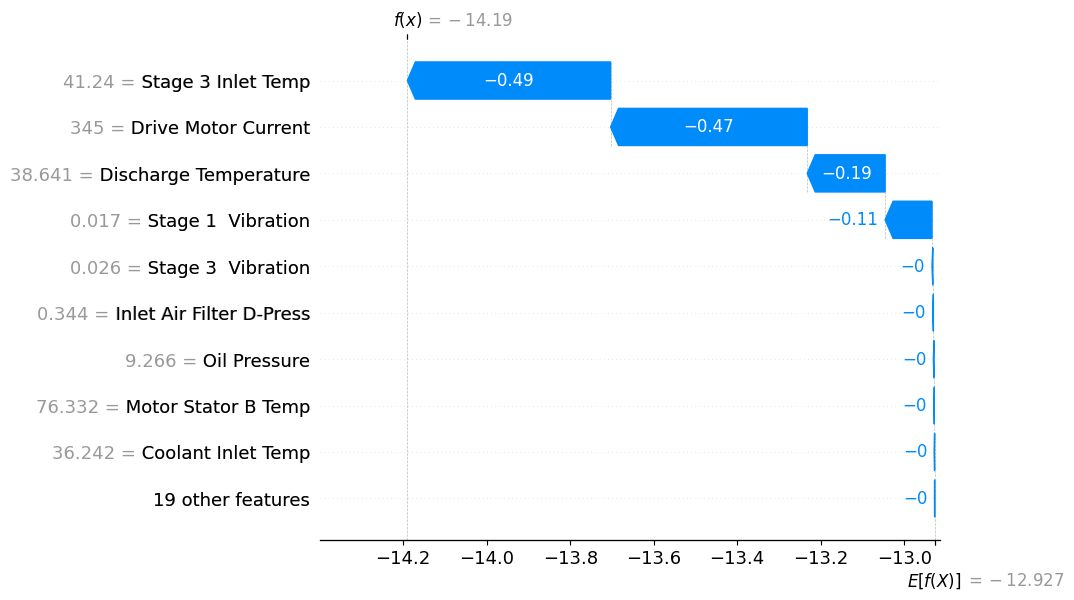

In [22]:
# shap value 로 그래프 그리기
# - xgboost

shap_xgb_list = [shap_value_xgb_0003, shap_value_xgb_0004, shap_value_xgb_0005]

for shap_value in shap_xgb_list:
    shap.plots.waterfall(shap_value[0])

In [23]:
# catBoost 모델에 대한 shap value 구하기

explainer_cat_0003 = shap.Explainer(cat_0003)
shap_value_cat_0003 = explainer_cat_0003(x_train_0003)

explainer_cat_0004 = shap.Explainer(cat_0004)
shap_value_cat_0004 = explainer_cat_0004(x_train_0004)

explainer_cat_0005 = shap.Explainer(cat_0005)
shap_value_cat_0005 = explainer_cat_0005(x_train_0005)

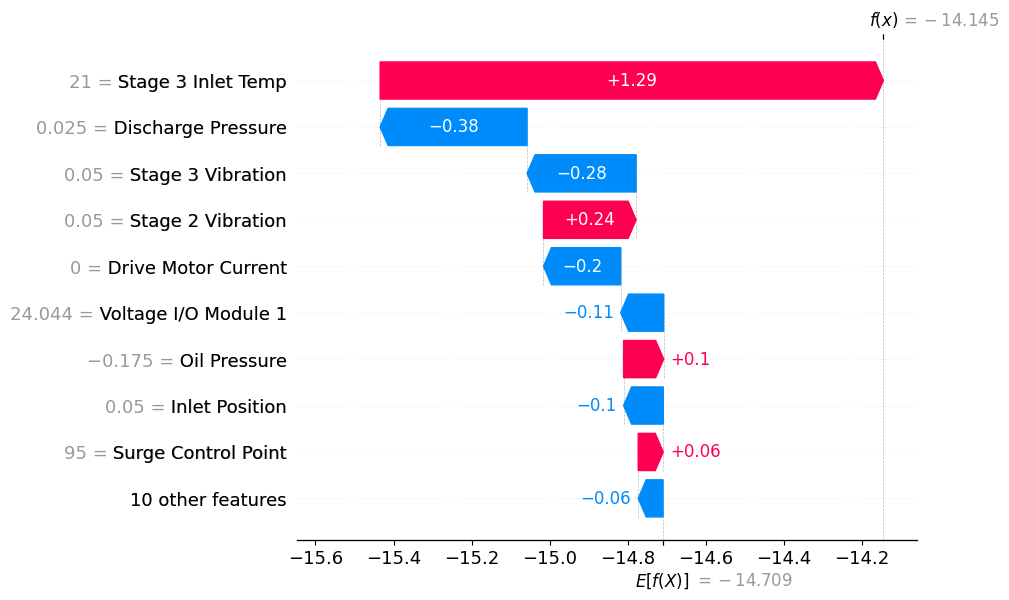

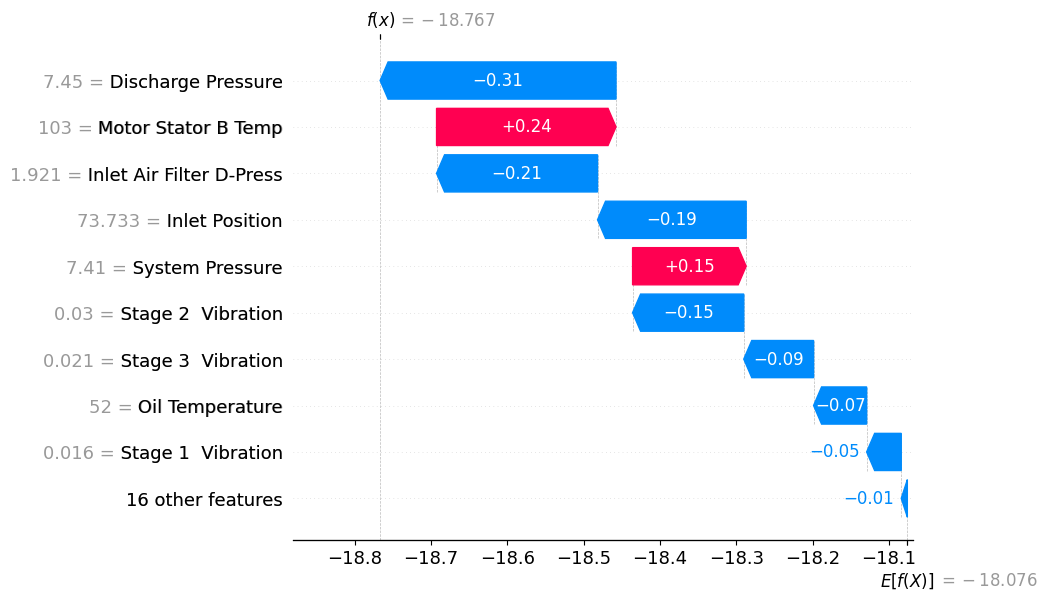

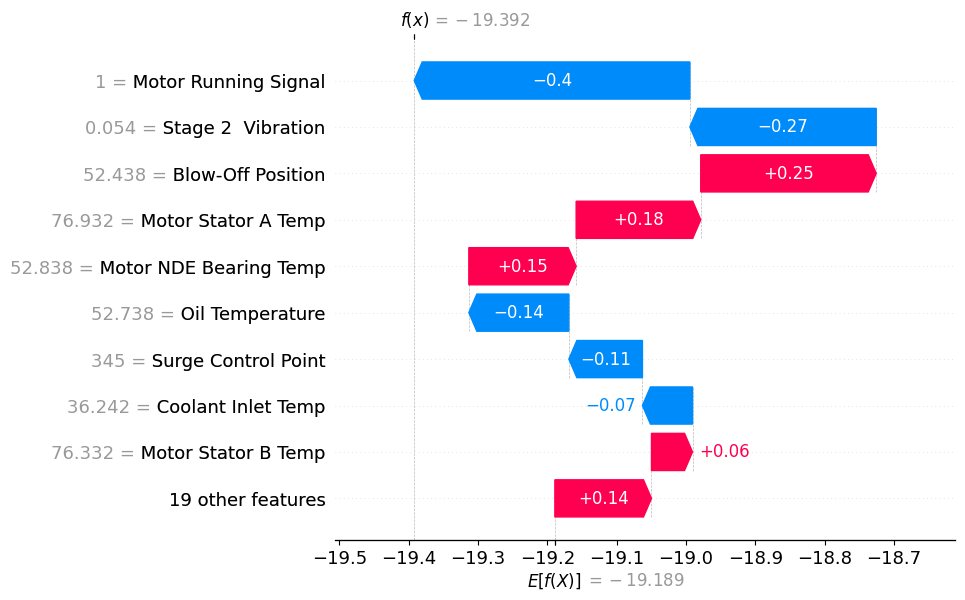

In [24]:
# shap value 로 그래프 그리기
# - catboost

shap_cat_list = [shap_value_cat_0003, shap_value_cat_0004, shap_value_cat_0005]

for shap_value in shap_cat_list:
    shap.plots.waterfall(shap_value[0])

## Column 별 shap value 추출 함수 구현
~~~
가능한 모델 : XGBoost, CatBoost
~~~

```python
input :
    model(xgboost, catboost) : 이미 학습한 모델
    X(pandas.DataFrame) : model 학습에 필요한 데이터
    
output :
    {
        column_name1 : shap_value,
        column_name2 : shap_value,
        ...
    }
```

In [27]:
def get_shap_value(model, X):
    # model : xgboost, catboost 등 학습이 완료된 모델
    # X : 모델 학습시 사용해던 데이터 [DataFrame]
    explainer = shap.Explainer(model)
    shap_value = explainer(X)[0].values
    column_names = X.columns

    result = {}
    for index, col in enumerate(column_names):
        result[col] = shap_value[index]
    
    return result

In [28]:
# 예시 사용방법
test_shap_value = get_shap_value(cat_0003, x_train_0003)
test_shap_value

{'System Pressure': -0.04870254917542129,
 'Discharge Pressure': -0.3763954591605158,
 'Stage 3 Inlet Temp': 1.2891828550854094,
 'Stage 1 Vibration': -4.385428721371008e-06,
 'Stage 2 Vibration': 0.23727479697802975,
 'Stage 3 Vibration': -0.2793438470016946,
 'Oil Pressure': 0.10257798401678603,
 'Oil Temperature': 0.0,
 'Drive Motor Current': -0.19777295868391706,
 'Surge Count': -0.035903316531003565,
 'Surge Control Point': 0.06414395190087016,
 'Blow-Off Position': 0.021526506223508775,
 'Oil level Switch': 0.0,
 'Motor Running Signal': 0.0,
 'Emergency Stop': 0.0,
 'Starter Fault': 0.0,
 'Surge Watch Motor': -0.0005839397672004471,
 'Inlet Position': -0.10159285099903605,
 'Voltage I/O Module 1': -0.11002707541269682}